## MLX U-Net

The raw math is used in this notebook according to the paper [Denoising Diffusion Probablistic Models](https://arxiv.org/pdf/2006.11239), all credit to the authors for the math used.

Set up imports. Make sure you're running this on a Mac OS device for MLX support. Ensure all dependencies are installed from `requirements.txt` as well!

In [1]:
import glob

# Core MLX imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# MLX data loading library
import mlx.data as dx
from mlx.data.datasets import load_mnist

# Visualization Tools
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# import torchvision for loading datasets and transformations
import torchvision
import torchvision.transforms as transforms

Define the functions to load and transform the dataset

In [2]:
# Perform transformation augmentation on the dataset
def load_transform_MNIST(img_size, batch_size):
    # load the raw data
    mnist_train = load_mnist(train=True)
    mnist_test = load_mnist(train=False)

    # build the stream and transform the data
    train_dataloader = (
        mnist_train
        .shuffle()
        .to_stream()
        .image_resize("image", h=img_size, w=img_size)
        .key_transform("image", lambda x: x.astype("float32") / 255.0)
        .batch(batch_size)
        .prefetch(4, 2)
    )

    test_dataloader = (
        mnist_test
        .to_stream()
        .image_resize("image", h=img_size, w=img_size)
        .key_transform("image", lambda x: x.astype("float32") / 255.0)
        .batch(batch_size)
        .prefetch(4, 2)
    )

    return train_dataloader, test_dataloader

Set up constants and get data

In [3]:
# 28x28 pixel images for MNIST
IMG_SIZE = 28
# 1 channel for grayscale images
IMG_CH = 1
# 128 images per batch
BATCH_SIZE = 128
# 10 output classes for digits 0-9
N_CLASSES = 10
train_loader, test_loader = load_transform_MNIST(IMG_SIZE, BATCH_SIZE)

# Check for metal availablity
mx.metal.is_available()

True

## Set up Diffusion

In [4]:
# defined in this way for visualization purposes
nrows = 10
ncols = 15

# total timesteps
T = nrows * ncols

# the boundaries for beta
B_start = 0.0001
B_end = 0.02

# turn it into a linear schedule
B = mx.linspace(start=B_start, stop=B_end, num=T)

Math out the variables that will be used in the `q` and `reverse_q` functions. `q` is the forward pass of diffusion that slowly destroys the image overtime by adding gaussian noise ("static") slowly at the beta schedule. Reverse q (normally referred to as 'p') does the opposite and is used by the diffusion model to go from pure gaussian noise ("static") to a final image, based on the weights the model learns.

In [5]:
a = 1.0 - B
a_bar = mx.cumprod(a, axis=0)
sqrt_a_bar = mx.sqrt(a_bar)
sqrt_one_minus_a_bar = mx.sqrt(1.0 - a_bar)

# Reverse q / diffusion variables
sqrt_a_inv = mx.sqrt(1.0 / a)
pred_noise_coeff = (1.0 - a) / mx.sqrt(1.0 - a_bar)

Define the `q` function, this will allow us to jump the image to the exact noisy state we need during training


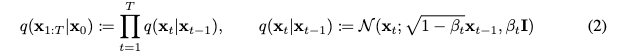

In [6]:
def q(x_0, t):
    t = mx.array(t, dtype=mx.int64)
    # gaussian noise
    noise = mx.random.normal(shape=x_0.shape, dtype=x_0.dtype)

    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]
    
    # add "faded" version of image + noise together
    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

Verify that `q` is working correctly

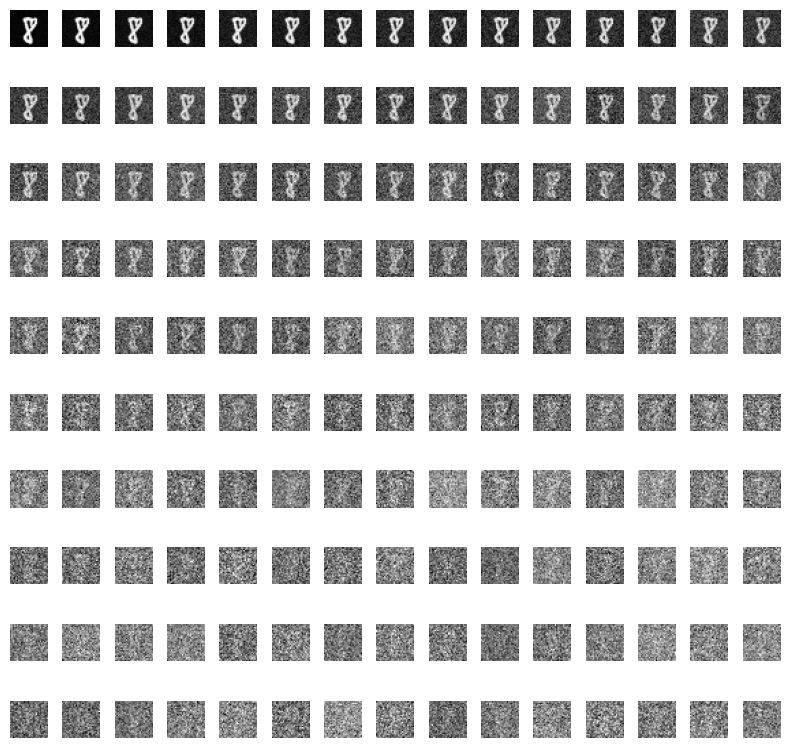

In [7]:
plt.figure(figsize=(8, 8))
batch = next(iter(train_loader))

# Take the first image from the batch and copy it into an MLX array
x_0 = mx.array(batch["image"][:1])

# keeps track of our corrupted images
xs = []

# T represents the total amount of "corruption" steps
for t in range(T):
    t_tensor = mx.array([t], dtype=mx.int64)
    x_t, _ = q(x_0, t_tensor)
    img = np.array(mx.squeeze(x_t[0]))
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis("off")
    plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

Now we implement the `reverse_q` function. This is what's used for sampling during training.

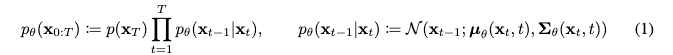

In [8]:
def reverse_q(x_t, t, e_t):
    t = mx.array(t, dtype=mx.int64)

    # explicitly broadcast the coefficients
    pred_noise_coeff_t = pred_noise_coeff[t][..., None, None, None]
    sqrt_a_inv_t = sqrt_a_inv[t][..., None, None, None]

    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if mx.squeeze(t[0]) == 0:
        return u_t # reverse diffusion complete
    else:
        # broadcast B_t to match x_t shape
        B_t = B[t - 1][..., None, None, None] # apply noise from previous timestep
        new_noise = mx.random.normal(shape=x_t.shape, dtype=x_t.dtype)
        return u_t + mx.sqrt(B_t) * new_noise

## Setting up the U-Net

Define the U-Net class

In [9]:
# write a small unflatten helper class since mlx does not have an equivalent to PyTorch's nn.Unflatten
class Unflatten(nn.Module):
    def __init__(self, axis, shape):
        super().__init__()
        self.axis = axis
        self.shape = shape

    def __call__(self, x):
        # We assume the batch dimension is 0 and we are unflattening axis 1
        # Logic: We take the input shape, keep the batch, and splice in our new shape
        # For NHWC, this will be (B, H, W, C)
        return x.reshape(x.shape[0], *self.shape)

# small helper function for the equivlalent of nn.Flatten in PyTorch
class Flatten(nn.Module):
    def __call__(self, x):
        return x.flatten(1)

class UNet(nn.Module):
    def __init__(
      self, T, img_ch, img_size, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=10      
    ):
        super().__init__()
        self.T = T
        up_chs = down_chs[::-1]
        latent_image_size = img_size // (2 ** (len(down_chs) - 1))
        small_group_size = 8
        big_group_size = 32

        # Initial Convolution
        self.down0 = ResidualConvBlock(img_ch, down_chs[0], small_group_size)

        # Downsampling layers
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )

        # time embeddings
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsampling layers (NHWC)
        self.up0 = nn.Sequential(
            Unflatten(1, (latent_image_size, latent_image_size, up_chs[0])),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatentation (NHWC)
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def __call__(self, x, t, c, c_mask):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = mx.array(t, dtype=mx.float32) / self.T # Convert from [0, T] to [0.0, 1.0]
        t = self.sinusoidaltime(t)
        t_emb1 = self.t_emb1(t)
        t_emb2 = self.t_emb2(t)

        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)

        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)
        return self.out(mx.concat([up2, down0], axis=-1))

## Define the Block classes

We left these undefined in the definition of the U-Net class so we will define them now

In [10]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def __call__(self, x):
        return self.model(x)

In [11]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            # NHWC: broadcast along spatial with channel last
            Unflatten(1, (1, 1, emb_dim)),
        ]
        self.model = nn.Sequential(*layers)
    
    def __call__(self, x):
        x = x.reshape(-1, self.input_dim)
        return self.model(x)

In [12]:
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)
    
    def __call__(self, x):
        return self.model(x)

In [13]:
# we need to import einops fo reshaping the array
import einops

class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        # NHWC: channel last with 4x channels after rearrange
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)
    
    def __call__(self, x):
        # Keep einops and convert arrays temporarily for NHWC pixel-unshuffle 2x2
        # Input NHWC: (b, h*p1, w*p2, c) -> (b, h, w, c*p1*p2)
        x_np = np.array(x)
        x_np = einops.rearrange(x_np, "b (h p1) (w p2) c -> b h w (c p1 p2)", p1=2, p2=2)
        x = mx.array(x_np)
        return self.conv(x)

In [14]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def __call__(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [15]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def __call__(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = mx.exp(mx.arange(half_dim) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = mx.concat([mx.sin(embeddings), mx.cos(embeddings)], axis=1)
        return embeddings

In [16]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size=2, stride=2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)
    
    def __call__(self, x, skip):
        # Concatenate along channel (last) axis for NHWC
        x = mx.concat([x, skip], axis=-1)
        x = self.model(x)
        return x

Now we can define our U-Net!

In [17]:
model = UNet(T, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES)

## Model Training

We begin by creating the `get_context_mask` function which will randomly drop the context to allow the model to learn when no input is present (optimize slightly for the "generic case")

In [18]:
def get_context_mask(c, drop_prob):
    c = mx.array(c, dtype=mx.int32)

    c_hot = mx.eye(N_CLASSES)[c]
    c_mask = mx.random.bernoulli(p=(1 - drop_prob), shape=c_hot.shape).astype(mx.float32)
    return c_hot, c_mask

Implement the loss function

In [19]:
def loss_fn(model, x, t, c_hot, c_mask):
    x_noisy, noise = q(x, t)
    noise_pred = model(x_noisy, t, c_hot, c_mask)
    return nn.losses.mse_loss(noise_pred, noise)

Sample the images during training for inspection

In [20]:
def sample_images(model, img_ch, img_size, ncols, *model_args, axis_on=False):
    # Noise to generate images from (NHWC channels-last)
    x_t = mx.random.normal(shape=(1, img_size, img_size, img_ch))
    plt.figure(figsize=(8, 8))
    # ensure integer step interval per column
    hidden_rows = max(1, T // ncols)
    plot_number = 1

    # Go from T to 0 removing and adding noise until t = 0
    for i in range(T - 1, -1, -1):
        t = mx.full((1,), i, dtype=mx.float32)
        e_t = model(x_t, t, *model_args)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0 and plot_number <= (ncols + 1):
            ax = plt.subplot(1, ncols + 1, plot_number)
            if not axis_on:
                ax.axis("off")
            img = np.array(mx.squeeze(x_t))
            ax.imshow(img, cmap="gray")
            plot_number += 1

    plt.tight_layout()
    plt.show()

Write the training loop

Epochs: 5
Epoch 0, Step 0, Label: 0, Loss: 1.1533


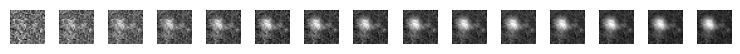

Epoch 0, Step 100, Label: 1, Loss: 0.1186


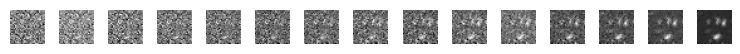

Epoch 0, Step 200, Label: 2, Loss: 0.0931


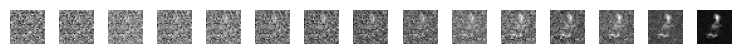

Epoch 0, Step 300, Label: 3, Loss: 0.0742


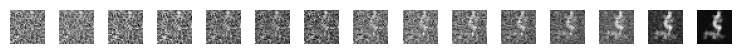

Epoch 0, Step 400, Label: 4, Loss: 0.0618


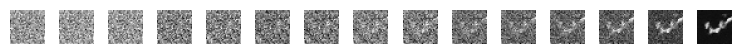

Epoch 0, Step 0, Label: 5, Loss: 0.0533


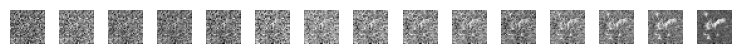

Epoch 0, Step 70, Label: 6, Loss: 0.0711


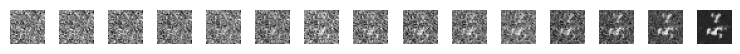

Epoch 1, Step 0, Label: 7, Loss: 0.0618


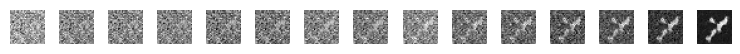

Epoch 1, Step 100, Label: 8, Loss: 0.0620


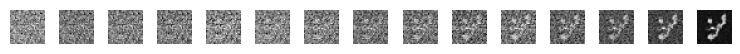

Epoch 1, Step 200, Label: 9, Loss: 0.0539


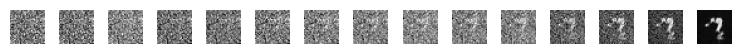

Epoch 1, Step 300, Label: 0, Loss: 0.0555


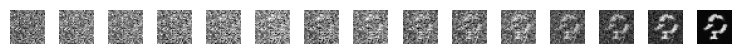

Epoch 1, Step 400, Label: 1, Loss: 0.0540


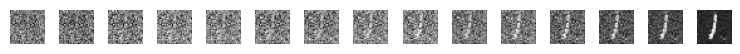

Epoch 1, Step 0, Label: 2, Loss: 0.0491


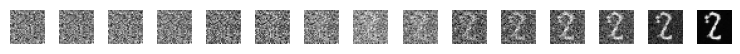

Epoch 1, Step 70, Label: 3, Loss: 0.0561


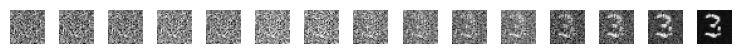

Epoch 2, Step 0, Label: 4, Loss: 0.0516


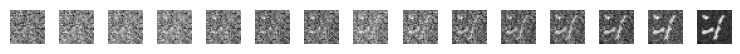

Epoch 2, Step 100, Label: 5, Loss: 0.0555


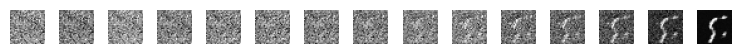

Epoch 2, Step 200, Label: 6, Loss: 0.0472


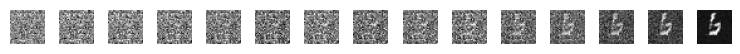

Epoch 2, Step 300, Label: 7, Loss: 0.0563


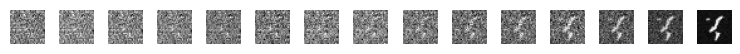

Epoch 2, Step 400, Label: 8, Loss: 0.0506


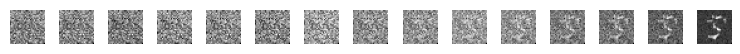

Epoch 2, Step 0, Label: 9, Loss: 0.0454


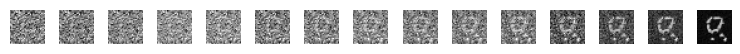

Epoch 2, Step 70, Label: 0, Loss: 0.0444


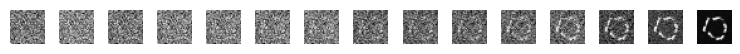

Epoch 3, Step 0, Label: 1, Loss: 0.0504


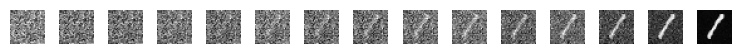

Epoch 3, Step 100, Label: 2, Loss: 0.0468


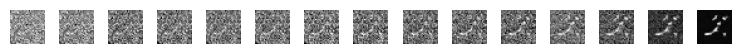

Epoch 3, Step 200, Label: 3, Loss: 0.0458


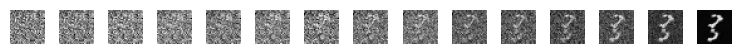

Epoch 3, Step 300, Label: 4, Loss: 0.0511


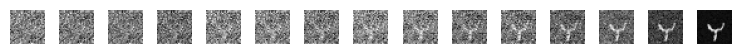

Epoch 3, Step 400, Label: 5, Loss: 0.0453


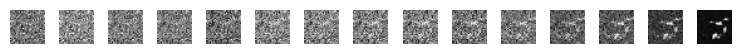

Epoch 3, Step 0, Label: 6, Loss: 0.0413


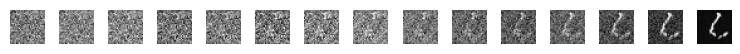

Epoch 3, Step 70, Label: 7, Loss: 0.0470


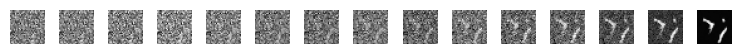

Epoch 4, Step 0, Label: 8, Loss: 0.0505


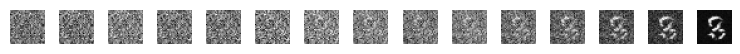

Epoch 4, Step 100, Label: 9, Loss: 0.0476


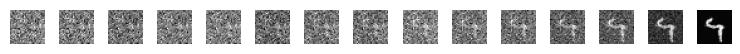

Epoch 4, Step 200, Label: 0, Loss: 0.0442


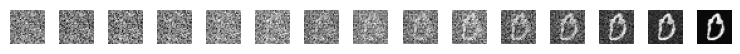

Epoch 4, Step 300, Label: 1, Loss: 0.0423


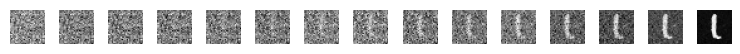

Epoch 4, Step 400, Label: 2, Loss: 0.0442


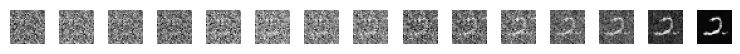

Epoch 4, Step 0, Label: 3, Loss: 0.0381


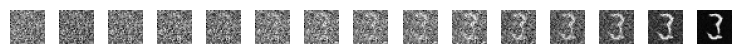

Epoch 4, Step 70, Label: 4, Loss: 0.0413


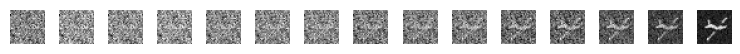

In [21]:
optimizer = optim.Adam(learning_rate=0.001)
epochs = 5
preview_c = 0

grad_fn = nn.value_and_grad(model, loss_fn)

print(f"Epochs: {epochs}")
for epoch in range(epochs):
    model.train()

    # since train loader is an iterable redefine it each time
    temp_train_loader, _ = load_transform_MNIST(IMG_SIZE, BATCH_SIZE)
    for step, batch in enumerate(temp_train_loader):
        c_drop_prob = 0.1

        # draw random timesteps per sample in this batch
        t = mx.random.randint(0, T, shape=(batch["image"].shape[0],)).astype(mx.float32)
        x = mx.array(batch["image"])  # images from dataloader
        c = batch["label"]            # integer class labels
        c_hot, c_mask = get_context_mask(c, c_drop_prob)  # context drop probability

        loss, grads = grad_fn(model, x, t, c_hot, c_mask)
        optimizer.update(model, grads)

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}, Label: {preview_c}, Loss: {loss.item():.4f}")
            c_drop_prob = 0.0  # no context dropping for preview
            c_hot, c_mask = get_context_mask(mx.array([preview_c]), c_drop_prob)
            sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES
    
    # evaluation every epoch
    _, temp_test_loader = load_transform_MNIST(IMG_SIZE, BATCH_SIZE)
    model.eval()

    for step, batch in enumerate(temp_test_loader):
        c_drop_prob = 0.1

        # draw random timesteps per sample in this batch
        t = mx.random.randint(0, T, shape=(batch["image"].shape[0],)).astype(mx.float32)
        x = mx.array(batch["image"])  # images from dataloader
        c = batch["label"]            # integer class labels
        c_hot, c_mask = get_context_mask(c, c_drop_prob)  # context drop probability

        loss, _ = grad_fn(model, x, t, c_hot, c_mask)

        if step % 70 == 0:
            print(f"TEST: Epoch {epoch}, Step {step}, Label: {preview_c}, Loss: {loss.item():.4f}")
            c_drop_prob = 0.0  # no context dropping for preview
            c_hot, c_mask = get_context_mask(mx.array([preview_c]), c_drop_prob)
            sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES